# 11. TRPO
trust region policy optimization

## 11.1. Intro

## 11.2. Policy Target

$$
\begin{aligned}
J(\theta) &= \mathbb{E}_{s_0}[V^{\pi_\theta}(s_0)] \\ 
&= \mathbb{E}_{\pi_{\theta'}}[\sum_{t=0}^\infin\gamma^tV^{\pi_\theta}(s_t) - \sum_{t=1}^\infin\gamma^tV^{\pi_\theta}(s_t)] \\
&= -\mathbb{E}_{\pi_{\theta'}}[\sum_{t=0}^\infin\gamma^t(V^{\pi_\theta}(s_{t+1}) - V^{\pi_\theta}(s_t))]
\end{aligned}
$$

$$
\begin{aligned}
J(\theta') - J(\theta) &= \mathbb{E}_{s_0}[V^{\pi_{\theta'}}(s_0)] - \mathbb{E_0}[V^{\pi_\theta}(s_0)] \\
&= \mathbb{E}_{\pi_{\theta'}}[\sum_{t=0}^\infin\gamma^t r(s_t, a_t)] + \mathbb{E}_{\pi_{\theta'}}[\sum_{t=0}^\infin\gamma^t (\gamma V^{\pi_\theta}(s_{t + 1}) - V^{\pi_\theta}(s_t))] \\
&= \mathbb{E}_{\pi_{\theta'}}[\sum_{t=0}^\infin\gamma^t(r(s_t, a_t) + \gamma V^{\pi_\theta}(s_{t + 1}) -  V^{\pi_\theta}(s_t))] \\ 
&= \mathbb{E}_{\pi_{\theta'}}[\sum_{t=0}^\infin \gamma^t A^{\pi_\theta}(s_t, a_t)] \quad 定义 \\
&= \sum_{t=0}^\infin \gamma^t\mathbb{E}_{s_t \sim P_{t}^{\pi_{\theta'}}}\mathbb{E}_{a_t \sim \pi_{\theta'}(\cdot | s_t)} [A^{\pi_\theta}(s_t, a_t)] \\ 
&= \frac1{1 - \gamma} \mathbb{E}_{s_t \sim v^{\pi_{\theta'}}}\mathbb{E}_{a \sim \pi_{\theta'}(\cdot | s_t)} [A^{\pi_\theta}(s_t, a_t)]
\end{aligned}
$$

$v^\pi(s) = (1 - \gamma)\sum_{t=0}^\infin \gamma^t P_t^\pi(s)$

定义替代目标：

$$
L_\theta(\theta') = J(\theta) + \frac1{1 - \gamma} \mathbb{E}_{s \sim v^{\pi_{\theta}}}\mathbb{E}_{a \sim \pi_{\theta'}(\cdot | s_t)} [A^{\pi_\theta}(s_t, a_t)]
$$

$$
L_\theta(\theta') = J(\theta) + \mathbb{E}_{s \sim v^{\pi_{\theta}}}\mathbb{E}_{a \sim \pi_{\theta}(\cdot | s_t)} [\frac{\pi_{\theta'}(a | s)}{\pi_{\theta}(a|s)}A^{\pi_\theta}(s, a)]
$$

整体目标：

$$
\max_{\theta'} L_\theta(\theta'), \text{s.t.} \mathbb{E}_{s \sim v^{\pi_{\theta_k}}}[D_{KL}(\pi_{\theta_k}(\cdot | s), \pi{\theta'}(\cdot | s))] \leq \delta
$$

## 11.3.

在$\theta_k$上泰勒展开：

$$
\mathbb{E}_{s \sim v^{\pi_{\theta_k}}}\mathbb{E}_{a \sim \pi_{\theta_k}(\cdot | s_t)} [\frac{\pi_{\theta'}(a | s)}{\pi_{\theta_k}(a|s)}A^{\pi_{\theta_k}}(s, a)] \approx g^T(\theta' - \theta_k)
$$

$$
\mathbb{E}_{s \sim v^{\pi_{\theta_k}}}[D_{KL}(\pi_{\theta_k}(\cdot | s), \pi{\theta'}(\cdot | s))] \approx \frac12(\theta' - \theta_k)^T H (\theta' - \theta_k)
$$

其中 $g = \nabla_{\theta'}\mathbb{E}_{s \sim v^{\pi_{\theta_k}}}\mathbb{E}_{a \sim \pi_{\theta_k}(\cdot | s_t)} [\frac{\pi_{\theta'}(a | s)}{\pi_{\theta_k}(a|s)}A^{\pi_{\theta_k}}(s, a)]$, 为梯度 而 $H = \mathrm{H}[\mathbb{E}_{s \sim v^{\pi_{\theta_k}}}[D_{KL}(\pi_{\theta_k}(\cdot | s), \pi{\theta'}(\cdot | s))]]$为黑塞矩阵

目标化为
$$
\theta_{k + 1} = \argmax_{\theta'} g^T(\theta' - \theta_k), s.t. \frac12(\theta' - \theta_k)^TH(\theta' - \theta_k) \leq \delta
$$

用KKT条件解出：
$$
\theta_{k + 1} = \theta_k + \sqrt{\frac{2\delta}{g^TH^{-1}g}}H^{-1}g
$$

## 11.4. Conjugate Gradient Method (共轭梯度)
提前计算出$x = H^{-1}g$, 更新为：
$$
\theta_{k + 1} = \theta_k + \sqrt{\frac{2\delta}{x^THx}}x
$$

算法：
伪代码 共轭梯度：
1. 初始化$r_0 = g - Hx_0, p_0 = r_0, x_0 = 0$
2. **for**  $k = 0 \rightarrow N$ **do**:
   1. $\alpha_k = \frac{r_k^Tr_k}{p^T_kHp_k}$ 
   2. $x_{k + 1} = x_k + \alpha_k p_k$
   3. $r_{k + 1} = r_k - \alpha_k H p_k$
   4. 如果$r_{k + 1}^Tr_{k+1}$过小，退出
   5. $\beta_k = \frac{r_{k+1}^Tr_{k+1}}{r_k^Tr_k}$
   6. $p_{k+1} = r_{k+1} + \beta_kp_k$
3. **end for**
4. 输出$x_{N + 1}$

为了避免存储巨大的$H$矩阵，我们仅仅计算$Hx$, 有
$$
Hv = \nabla_\theta((\nabla_\theta(D_{KL}^{v^{\pi_{\theta_k}}}(\pi_{\theta_k}, \pi_{\theta'})))^T)v = \nabla_\theta((\nabla_\theta(D_{KL}^{v^{\pi_{\theta_k}}}(\pi_{\theta_k}, \pi_{\theta'}))))^Tv
$$

## 11.5. 线性搜索
参数控制搜索长度
$$
\theta_{k + 1} = \theta_k + \alpha^i\sqrt{\frac{2\delta}{x^THx}}x
$$

算法：
伪代码 TRPO：
1. 随机初始化策略网络参数$\theta$和价值网络参数$\omega$
2. **for**  $e = 1 \rightarrow E$ **do**:
   1. 用当前策略$\pi_\theta$采样轨迹 $\left\{s_1, a_1, r_1, s_2, a_2, r_2, ..., ..., \right\}$
   2. 根据收集到的数据和价值网络估计每个状态动作对的优势$A(s_t, a_t)$
   3. 计算策略目标函数的梯度$g$
   4. 用共轭梯度法计算$x = H^{-1}g$
   5. 线性搜索找到$i$, 更新策略网络参数$\theta_{k + 1} = \theta_k + \alpha^i\sqrt{\frac{2\delta}{x^THx}}$, 其中$i \in \left\{1, 2, ..., ..., K\right\}$为能提升策略并且满足KL距离限制的最小整数
   6. 更新价值网络参数 
3. **end for**

## 11.6. Generalized Advantage Estimation(GAE) 广义优势估计

$\delta_t = r_t + \gamma V(s_{t+1}) - V(s_t)$ 时序差分误差，$V$: 已经学习的状态价值函数

$$
A_t^{(k)} = \sum_{l = 0}^{k - 1}\gamma^l \delta_{t + l} = - V(s_t) + \sum_{i = 0}^{k-1} \gamma^{i}r_{t + i} + \gamma^k V(s_{t + k})
$$

$$
A_t^{GAE} = (1 - \lambda)(\sum_{i = 1}^\infin \lambda^{i - 1} A_t^{(i)}) =  \sum_{l=0}^\infin (\gamma\lambda)^l\delta_{t + l}
$$

$\lambda \in [0, 1]$是GAE引入的超参数，为0表示一步查分，为1表示每步。


In [12]:
import torch
import numpy as np
if not hasattr(np, "bool8"):
  np.bool8 = np.bool_ # 这样写np不用降级
import gym
import matplotlib.pyplot as plt
import torch.nn.functional as F
import rl_utils
import copy

In [13]:
def compute_advantage(gamma, lmbda, td_delta):
  td_delta = td_delta.detach().numpy()
  advantage_list = []
  advantage = 0.0
  for delta in td_delta[::-1]:
    advantage = gamma * lmbda * advantage + delta
    advantage_list.append(advantage)
  advantage_list.reverse()
  return torch.tensor(advantage_list, dtype=torch.float)

## 11.7. TRPO 代码

In [14]:
class PolicyNet(torch.nn.Module):
  """一层隐藏层的Q网络"""
  def __init__(self, state_dim, hidden_dim, action_dim):
    super(PolicyNet, self).__init__()
    self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
    self.fc2 = torch.nn.Linear(hidden_dim, action_dim)
    
  def forward(self, x):
    x = F.relu(self.fc1(x)) 
    return F.softmax(self.fc2(x), dim=1)
  
class ValueNet(torch.nn.Module):
  """一层隐藏层的Q网络"""
  def __init__(self, state_dim, hidden_dim):
    super(ValueNet, self).__init__()
    self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
    self.fc2 = torch.nn.Linear(hidden_dim, 1)
    
  def forward(self, x):
    x = F.relu(self.fc1(x)) 
    return self.fc2(x)
  
class TRPO:
  def __init__(self, hidden_dim, state_space, action_space,
                lmbda, kl_constraint, alpha, critic_lr, gamma, device):
    
    state_dim = state_space.shape[0]
    action_dim = action_space.n
    
    self.actor = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
    self.critic = ValueNet(state_dim, hidden_dim).to(device)
    # self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)
    self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=critic_lr)
    self.gamma = gamma
    self.lmbda = lmbda # GAE 参数
    self.kl_constraint = kl_constraint # KL约束
    self.alpha = alpha # 线性搜索参数
    self.device = device
    
  def take_action(self, state): # 根据动作概率分布随机采样
    state = torch.tensor([state], dtype=torch.float).to(self.device)
    probs = self.actor(state)
    action_dist = torch.distributions.Categorical(probs)
    action = action_dist.sample()
    return action.item()
  
  def hessian_matrix_vector_product(self, states, old_action_dists, vector):
    # 计算黑塞矩阵和一个向量的乘积
    new_action_dists = torch.distributions.Categorical(self.actor(states))
    kl = torch.mean(
      torch.distributions.kl.kl_divergence(old_action_dists, new_action_dists)
    ) # 计算KL平均距离
    kl_grad = torch.autograd.grad(kl,
                                  self.actor.parameters(),
                                  create_graph=True)
    kl_grad_vector = torch.cat([grad.view(-1) for grad in kl_grad])
    # 距离的梯度先和向量进行点积运算
    kl_grad_vector_product = torch.dot(kl_grad_vector, vector)
    grad2 = torch.autograd.grad(kl_grad_vector_product,
                                self.actor.parameters())
    grad2_vector = torch.cat([grad.view(-1) for grad in grad2])
    return grad2_vector
  
  def conjugate_gradient(self, grad, states, old_action_dists): 
    # 共轭梯度求解方程
    x = torch.zeros_like(grad)
    r = grad.clone()
    p = grad.clone()
    rdotr = torch.dot(r, r)
    for i in range(10):
      Hp = self.hessian_matrix_vector_product(states, old_action_dists, p)
      alpha = rdotr / torch.dot(p, Hp)
      x += alpha * p
      r -= alpha * Hp
      new_rdotr = torch.dot(r, r)
      if new_rdotr < 1e-10:
        break
      beta = new_rdotr / rdotr
      p = r + beta * p
      rdotr = new_rdotr
    return x
  
  def compute_surrogate_obj(self, states, actions, advantage, old_log_probs,
                            actor): # 计算策略目标
    log_probs = torch.log(actor(states).gather(1, actions))
    ratio = torch.exp(log_probs - old_log_probs)
    return torch.mean(ratio * advantage)
  
  def line_search(self, states, actions, advantage, old_log_probs,
                  old_action_dists, max_vec): # 线性搜索
    old_para = torch.nn.utils.convert_parameters.parameters_to_vector(
      self.actor.parameters()
    )
    old_obj = self.compute_surrogate_obj(states, actions, advantage, old_log_probs, self.actor)
    
    for i in range(15): # 主循环
      coef = self.alpha ** i
      new_para = old_para + coef * max_vec
      new_actor = copy.deepcopy(self.actor)
      torch.nn.utils.convert_parameters.vector_to_parameters(
        new_para, new_actor.parameters()
      )
      new_action_dists = torch.distributions.Categorical(
        new_actor(states)
      )
      kl_div = torch.mean(
        torch.distributions.kl.kl_divergence(old_action_dists, 
                                            new_action_dists)
      )
      new_obj = self.compute_surrogate_obj(states, actions, advantage, 
                                          old_log_probs, new_actor)
      if new_obj > old_obj and kl_div < self.kl_constraint:
        return new_para
    return old_para
  
  def policy_learn(self, states, actions, old_action_dists, old_log_probs, advantage):
    # 更新策略函数
    surrogate_obj = self.compute_surrogate_obj(states, actions, advantage,
                                              old_log_probs, self.actor)
    grads = torch.autograd.grad(surrogate_obj, self.actor.parameters())
    obj_grad = torch.cat([grad.view(-1) for grad in grads]).detach()
    # 共轭梯度法计算x = H^(-1)g
    descent_direction = self.conjugate_gradient(obj_grad, states,
                                                old_action_dists)
    Hd = self.hessian_matrix_vector_product(states, old_action_dists, 
                                            descent_direction)
    max_coef = torch.sqrt(2 * self.kl_constraint / 
                          (torch.dot(descent_direction, Hd) + 1e-8))
    new_para = self.line_search(states, actions, advantage, old_log_probs,
                                old_action_dists,
                                descent_direction * max_coef)
    # 线性搜索
    torch.nn.utils.convert_parameters.vector_to_parameters(
      new_para, self.actor.parameters()
    ) # 线性搜索后的参数更新策略
  
  def update(self, transition_dict):
    states = torch.tensor(transition_dict['states'], 
                          dtype=torch.float).to(self.device)
    actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(self.device)
    rewards = torch.tensor(transition_dict['rewards'],
                            dtype=torch.float).view(-1, 1).to(self.device)
    next_states = torch.tensor(transition_dict['next_states'],
                                dtype = torch.float).to(self.device)
    dones = torch.tensor(transition_dict['dones'],
                          dtype=torch.float).view(-1, 1).to(self.device)
    
    
    # 时序差分目标
    td_target = rewards + self.gamma * self.critic(next_states) * (1 - dones)
    td_delta = td_target - self.critic(states)
    advantage = compute_advantage(self.gamma, self.lmbda, 
                                  td_delta.cpu()).to(self.device)
    old_log_probs = torch.log(self.actor(states).gather(1, actions)).detach()
    old_action_dists = torch.distributions.Categorical(self.actor(states).detach())
    # 均方误差损失
    critic_loss = torch.mean(
      F.mse_loss(self.critic(states), td_target.detach())
    )
    self.critic_optimizer.zero_grad() 
    critic_loss.backward()
    self.critic_optimizer.step()
    self.policy_learn(states, actions, old_action_dists, old_log_probs, advantage)

Iteration 9: 100%|██████████| 50/50 [00:13<00:00,  3.65it/s, episode=500, return=500.000]


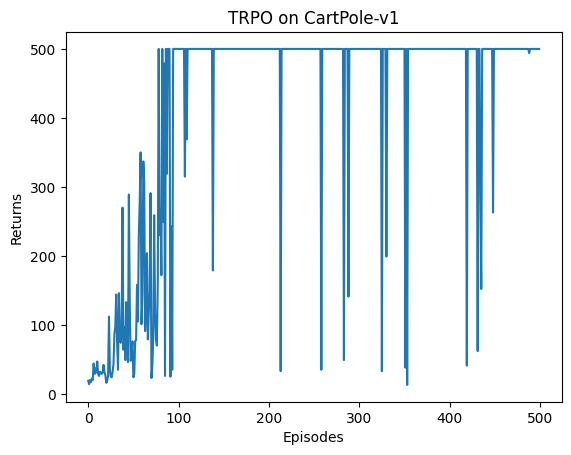

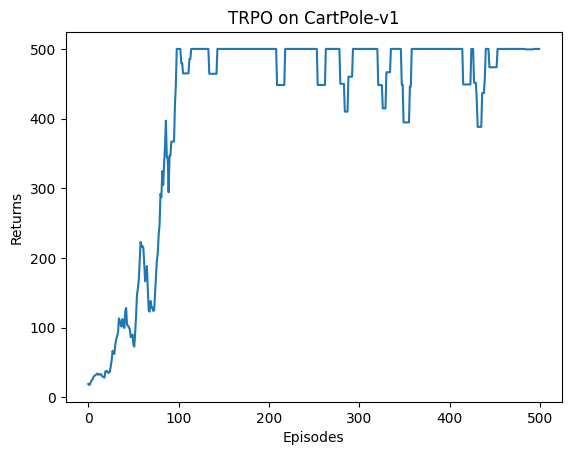

In [18]:
num_episodes = 500
hidden_dim = 128
gamma = 0.98
lmbda = 0.95
critic_lr = 1e-2
kl_constraint = 0.0005
alpha = 0.5
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

env_name ='CartPole-v1'
env = gym.make(env_name)
torch.manual_seed(0)
state_dim = env.observation_space
action_dim = env.action_space
agent = TRPO(hidden_dim, state_dim, action_dim, lmbda, 
            kl_constraint, alpha, critic_lr, gamma, device)

return_list = rl_utils.train_on_policy_agent(env, agent, num_episodes)

episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('TRPO on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('TRPO on {}'.format(env_name))
plt.show()

In [26]:
class PolicyNetContinuous(torch.nn.Module):
  """一层隐藏层的Q网络"""
  def __init__(self, state_dim, hidden_dim, action_dim):
    super(PolicyNetContinuous, self).__init__()
    self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
    self.fc_mu = torch.nn.Linear(hidden_dim, action_dim)
    self.fc_std = torch.nn.Linear(hidden_dim, action_dim)
    
  def forward(self, x):
    x = F.relu(self.fc1(x))
    mu = 2.0 * torch.tanh(self.fc_mu(x))
    std = F.softplus(self.fc_std(x)) 
    return mu, std # 高斯分布的均值和标准差
  
class TRPOContinuous:
  def __init__(self, hidden_dim, state_space, action_space,
                lmbda, kl_constraint, alpha, critic_lr, gamma, device):
    
    state_dim = state_space.shape[0]
    action_dim = action_space.shape[0]
    self.actor = PolicyNetContinuous(state_dim, hidden_dim, action_dim).to(device)
    self.critic = ValueNet(state_dim, hidden_dim).to(device)
    # self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)
    self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=critic_lr)
    self.gamma = gamma
    self.lmbda = lmbda # GAE 参数
    self.kl_constraint = kl_constraint # KL约束
    self.alpha = alpha # 线性搜索参数
    self.device = device
    
  def take_action(self, state): # 根据动作概率分布随机采样
    state = torch.tensor([state], dtype=torch.float).to(self.device)
    mu, std = self.actor(state) # ^^^^
    action_dist = torch.distributions.Normal(mu, std) #^^^^
    action = action_dist.sample()
    return [action.item()]
  
  def hessian_matrix_vector_product(self, states, old_action_dists, vector, damping=0.1):
    # 计算黑塞矩阵和一个向量的乘积
    mu, std = self.actor(states) # ^^^^
    new_action_dists = torch.distributions.Normal(mu, std) # ^^^^
    kl = torch.mean(
      torch.distributions.kl.kl_divergence(old_action_dists, new_action_dists)
    ) # 计算KL平均距离
    kl_grad = torch.autograd.grad(kl,
                                  self.actor.parameters(),
                                  create_graph=True)
    kl_grad_vector = torch.cat([grad.view(-1) for grad in kl_grad])
    # 距离的梯度先和向量进行点积运算
    kl_grad_vector_product = torch.dot(kl_grad_vector, vector)
    grad2 = torch.autograd.grad(kl_grad_vector_product,
                                self.actor.parameters())
    grad2_vector = torch.cat([grad.contiguous().view(-1) for grad in grad2]) # ^^^
    return grad2_vector + damping * vector #^^^
  
  def conjugate_gradient(self, grad, states, old_action_dists): 
    # 共轭梯度求解方程
    x = torch.zeros_like(grad)
    r = grad.clone()
    p = grad.clone()
    rdotr = torch.dot(r, r)
    for i in range(10):
      Hp = self.hessian_matrix_vector_product(states, old_action_dists, p)
      alpha = rdotr / torch.dot(p, Hp)
      x += alpha * p
      r -= alpha * Hp
      new_rdotr = torch.dot(r, r)
      if new_rdotr < 1e-10:
        break
      beta = new_rdotr / rdotr
      p = r + beta * p
      rdotr = new_rdotr
    return x
  
  def compute_surrogate_obj(self, states, actions, advantage, old_log_probs,
                            actor): # 计算策略目标
    mu, std =actor(states) # ^^^^^
    action_dists = torch.distributions.Normal(mu, std) # ^^^^
    log_probs = action_dists.log_prob(actions) # ^^^^^
    ratio = torch.exp(log_probs - old_log_probs)
    return torch.mean(ratio * advantage)
  
  def line_search(self, states, actions, advantage, old_log_probs,
                  old_action_dists, max_vec): # 线性搜索
    old_para = torch.nn.utils.convert_parameters.parameters_to_vector(
      self.actor.parameters()
    )
    old_obj = self.compute_surrogate_obj(states, actions, advantage, old_log_probs, self.actor)
    
    for i in range(15): # 主循环
      coef = self.alpha ** i
      new_para = old_para + coef * max_vec
      new_actor = copy.deepcopy(self.actor)
      torch.nn.utils.convert_parameters.vector_to_parameters(
        new_para, new_actor.parameters()
      )
      mu, std = new_actor(states) # ^^^^
      new_action_dists = torch.distributions.Normal(
        mu, std # ^^^^^
      )
      kl_div = torch.mean(
        torch.distributions.kl.kl_divergence(old_action_dists, 
                                            new_action_dists)
      )
      new_obj = self.compute_surrogate_obj(states, actions, advantage, 
                                          old_log_probs, new_actor)
      if new_obj > old_obj and kl_div < self.kl_constraint:
        return new_para
    return old_para
  
  def policy_learn(self, states, actions, old_action_dists, old_log_probs, advantage):
    # 更新策略函数
    surrogate_obj = self.compute_surrogate_obj(states, actions, advantage,
                                              old_log_probs, self.actor)
    grads = torch.autograd.grad(surrogate_obj, self.actor.parameters())
    obj_grad = torch.cat([grad.view(-1) for grad in grads]).detach()
    # 共轭梯度法计算x = H^(-1)g
    descent_direction = self.conjugate_gradient(obj_grad, states,
                                                old_action_dists)
    Hd = self.hessian_matrix_vector_product(states, old_action_dists, 
                                            descent_direction)
    max_coef = torch.sqrt(2 * self.kl_constraint / 
                          (torch.dot(descent_direction, Hd) + 1e-8))
    new_para = self.line_search(states, actions, advantage, old_log_probs,
                                old_action_dists,
                                descent_direction * max_coef)
    # 线性搜索
    torch.nn.utils.convert_parameters.vector_to_parameters(
      new_para, self.actor.parameters()
    ) # 线性搜索后的参数更新策略
  
  def update(self, transition_dict):
    states = torch.tensor(transition_dict['states'], 
                          dtype=torch.float).to(self.device)
    actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(self.device)
    rewards = torch.tensor(transition_dict['rewards'],
                            dtype=torch.float).view(-1, 1).to(self.device)
    next_states = torch.tensor(transition_dict['next_states'],
                                dtype = torch.float).to(self.device)
    dones = torch.tensor(transition_dict['dones'],
                          dtype=torch.float).view(-1, 1).to(self.device)
    
    rewards = (rewards + 8.0) / 8.0 # 对奖励进行修正，防止/0
    # 时序差分目标
    td_target = rewards + self.gamma * self.critic(next_states) * (1 - dones)
    td_delta = td_target - self.critic(states)
    advantage = compute_advantage(self.gamma, self.lmbda, 
                                  td_delta.cpu()).to(self.device)
    mu, std = self.actor(states) # ^^^^^
    old_action_dists = torch.distributions.Normal(mu.detach(), std.detach()) #^^^^
    old_log_probs = old_action_dists.log_prob(actions) # ^^^^
    # 均方误差损失
    critic_loss = torch.mean(
      F.mse_loss(self.critic(states), td_target.detach())
    )
    self.critic_optimizer.zero_grad() 
    critic_loss.backward()
    self.critic_optimizer.step()
    self.policy_learn(states, actions, old_action_dists, old_log_probs, advantage)

Iteration 9: 100%|██████████| 200/200 [00:26<00:00,  7.60it/s, episode=2000, return=-236.829]


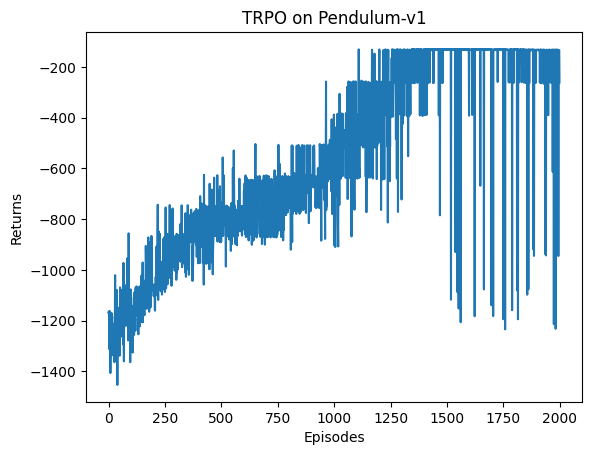

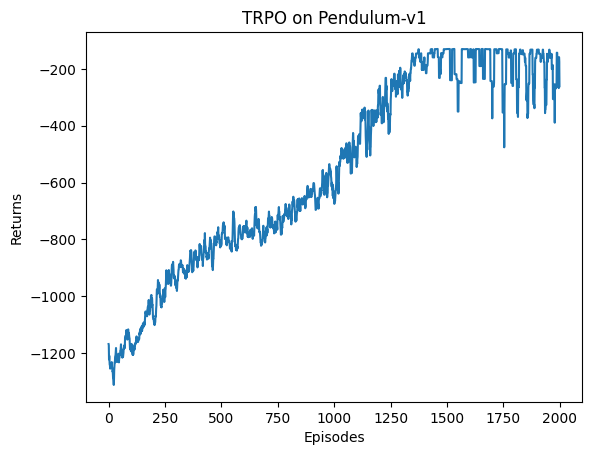

In [27]:
num_episodes = 2000
hidden_dim = 128
gamma = 0.9
lmbda = 0.9
critic_lr = 1e-2
kl_constraint = 0.00005
alpha = 0.5
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

env_name ='Pendulum-v1'
env = gym.make(env_name)
torch.manual_seed(0)
state_dim = env.observation_space
action_dim = env.action_space
agent = TRPOContinuous(hidden_dim, state_dim, action_dim, lmbda, 
            kl_constraint, alpha, critic_lr, gamma, device)

return_list = rl_utils.train_on_policy_agent(env, agent, num_episodes)

episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('TRPO on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('TRPO on {}'.format(env_name))
plt.show()